Rotation angles: [3.86948302 5.14576181 0.59566569 2.78937237 2.46839195 0.72253597]
Coupling map:


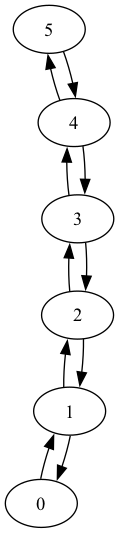

In [1]:
from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "ry", "rx", "ry", "rx", "ry"]
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, True)
print("Rotation angles:", rotation_angles)
print("Coupling map:")
cm.draw()

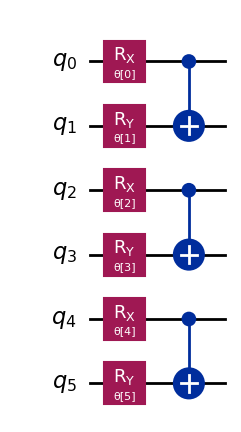

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

In [3]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.025  # γ_0->1
gamma_matrix[0, 3] = 0.3  # γ_0->3
gamma_matrix[1, 2] = 0.25  # γ_1->2
gamma_matrix[2, 3] = 0.0  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 4] = 0.025  # γ_5->4

gamma_matrix = np.random.uniform(0, 1, (num_qubits, num_qubits))
print("Gamma matrix:")
print(gamma_matrix)

Gamma matrix:
[[0.49323248 0.93218615 0.02423059 0.55443577 0.75271872 0.37124081]
 [0.3130065  0.94972152 0.69595304 0.38739087 0.28554046 0.54535124]
 [0.98204186 0.15943677 0.3388887  0.65856908 0.10764168 0.32581526]
 [0.34905584 0.58256809 0.79538475 0.37963582 0.9581025  0.57079956]
 [0.38475112 0.6530118  0.92343163 0.98901532 0.71056542 0.28941886]
 [0.52201094 0.40956642 0.70001358 0.19496023 0.33969939 0.51734985]]


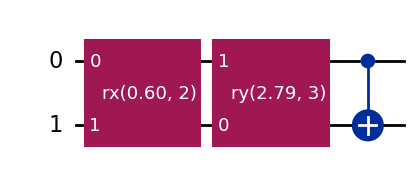

In [4]:
pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [5]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [6]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '42f9e32633d74edbb8864f554d11b30d',
   'operations': ['rx(0.60, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[-0.4341331 -0.44969843j,  0.05726199+0.7784734j ,
                0.        +0.j        ,  0.        +0.j        ],
              [-0.05726199+0.7784734j , -0.4341331 +0.44969843j,
                0.        +0.j        ,  0.        +0.j        ],
              [ 0.        +0.j        ,  0.        +0.j        ,
               -0.4341331 -0.44969843j,  0.05726199+0.7784734j ],
              [ 0.        +0.j        ,  0.        +0.j        ,
               -0.05726199+0.7784734j , -0.4341331 +0.44969843j]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': '41eccdfdb8ce426892a1af065a5ded3a',
   'operations': ['ry(2.79, 3)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[-0.22634665-0.23647721j,  0.        +0.

In [7]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[ 0.16748793+0.j        ,  0.        -0.05141265j,
           -0.94118828+0.j        ,  0.        +0.28891027j],
          [ 0.        -0.28891027j,  0.94118828+0.j        ,
            0.        -0.05141265j,  0.16748793+0.j        ],
          [ 0.94118828+0.j        ,  0.        -0.28891027j,
            0.16748793+0.j        ,  0.        -0.05141265j],
          [ 0.        -0.05141265j,  0.16748793+0.j        ,
            0.        +0.28891027j, -0.94118828+0.j        ]],
         input_dims=(2, 2), output_dims=(2, 2))


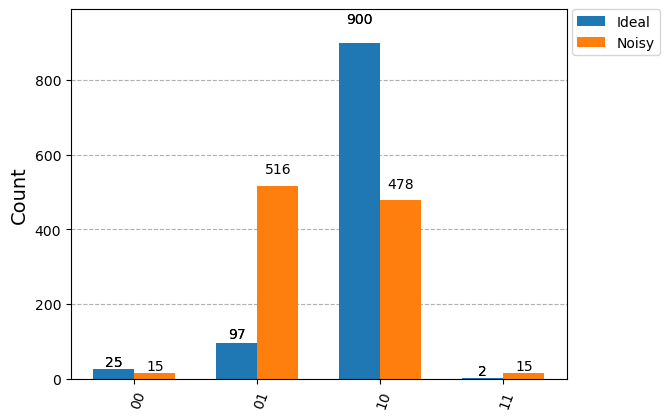

In [8]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [9]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
qc_noisy_ideal_state.save_statevector()
qc_noisy_state.save_statevector()

ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
noisy_state = backend.run(qc_noisy_state).result().get_statevector()

In [10]:
output_fidelity = state_fidelity(ideal_state, noisy_state)
output_fidelity

0.5630021993285861

In [11]:
from qiskit import QuantumRegister
from rl_qoc.helpers import get_gate

# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )

    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])
    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [12]:
# Define the environment
from gymnasium.spaces import Box
from gymnasium.wrappers import ClipAction
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    QiskitConfig,
)

action_space = Box(low=-0.2, high=0.2, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=64,
        n_reps=1,
        n_shots=50,
        sampling_paulis=100,
    ),
    reward_config="channel",
)
q_env = ContextAwareQuantumEnvironment(
    q_env_config,
    circuit_context=qc_noisy,  # Pass the circuit already transpiled through custom pass
)
rescaled_env = ClipAction(q_env)

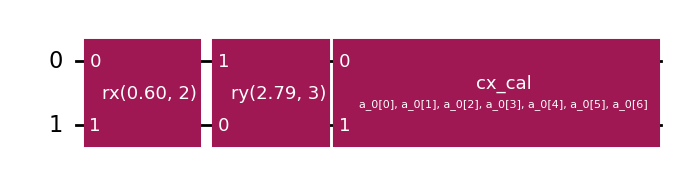

In [13]:
q_env.circuits[0].draw(output="mpl")

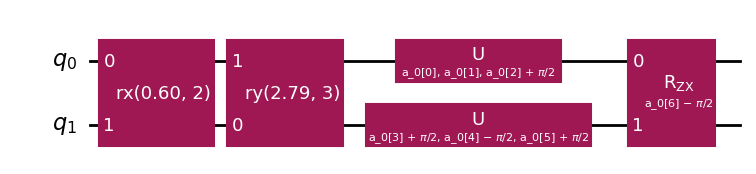

In [14]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [15]:
from rl_qoc.helpers import load_from_yaml_file
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = file_name

agent_config = load_from_yaml_file(file_location)

In [16]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 500
target_fidelities = [0.9]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

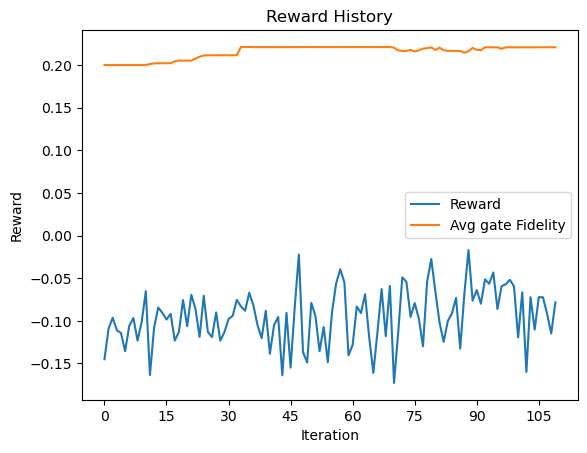

 22%|██▏       | 110/500 [01:29<05:19,  1.22it/s]

Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.22087899276442485
Avg gate fidelity: 0.22087899276442485
Finished simulation benchmark 

Sending Estimator job...


 22%|██▏       | 111/500 [01:30<05:11,  1.25it/s]

Time for running 0.2660059928894043
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.22084804784215378
Avg gate fidelity: 0.22084804784215378
Finished simulation benchmark 

Sending Estimator job...


 22%|██▏       | 112/500 [01:31<05:04,  1.27it/s]

Time for running 0.2519698143005371
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.22083001922846668
Avg gate fidelity: 0.22083001922846668
Finished simulation benchmark 

Sending Estimator job...


 23%|██▎       | 113/500 [01:32<05:01,  1.28it/s]

Time for running 0.25803685188293457
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.22082676121548253
Avg gate fidelity: 0.22082676121548253
Finished simulation benchmark 



 23%|██▎       | 113/500 [01:32<05:17,  1.22it/s]

Sending Estimator job...


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [17]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

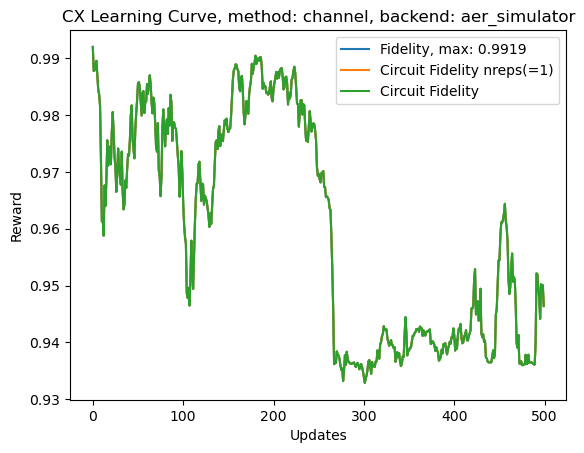

In [18]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

# plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(
    q_env.circuit_fidelity_history_nreps,
    label=f"Circuit Fidelity nreps(={q_env.n_reps})",
)
# plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

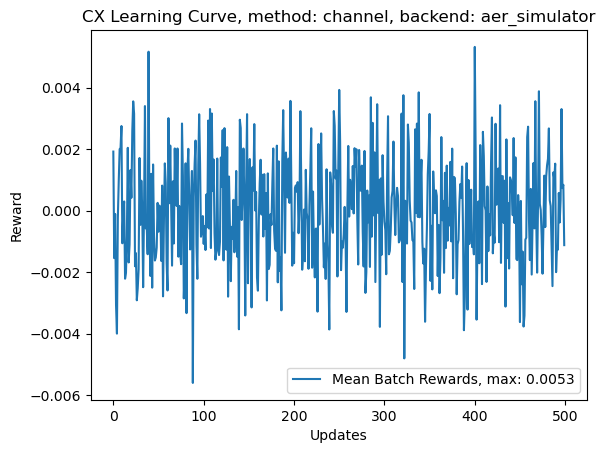

In [19]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
# plt.plot(
#     q_env.fidelity_history,
#     label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
# )
# plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
# plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
# plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [33]:
q_env.optimal_action

array([ 0.16718724, -0.1882672 , -0.16773811, -0.2       ,  0.02085974,
       -0.14108044,  0.2       ], dtype=float32)

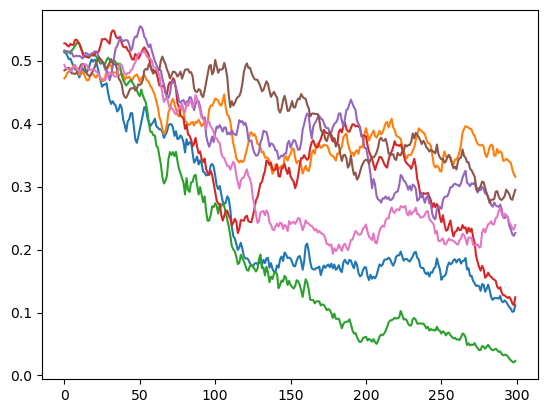

In [35]:
plt.plot(ppo_agent.training_results["std_action"])